# Data Merging

We have two sources of data: (a) **Justia data** (includes the text of the syllabi) and (b) **Supreme Court Database data** (includes metadata, i.e. voting outcomes and manually tagged issue areas). The best (yields most coverage) way to merge these two data sets is most easily done via the U.S. cite colume, which we scraped via the URLs for the Justia data. <br>

However, this task becomes somewhat nontrivial since the Supreme Court Database data has null fields for the U.S. cite column for years 2010 and beyond. This is because the notations format for Supreme Court cases transitioned during this year (Vol. 558). We can fix this missing data issue by scraping a mapped list (docket number to U.S. cite) via Wikipedia's comprehensive list of Supreme Court case citations by volume.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.notebook_repr_html", True)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

### Incorporating Text Data from Justia
To begin, we upload our main data source: syllabi of Supreme Court cases. A syllabus is the official summary of a Supreme Court decision, and is published by the Supreme Court together with the justices' opinions. Our sample is all Supreme Court cases since 1946. This is about 11,000 cases (an enormous amount of text), so we randomly sample 20% of these cases to make the problem more tractable. 

In [3]:
# read csv of syllabi to dataframe
justia_df = pd.read_csv("final_justia_data_merge.csv")
justia_df.head()

,full_cite,text,url,us_cite,year,case
0,Eagles v. Samuels 329 U.S. 304 (1946),"Eagles v. Samuels No. 59 Argued November 21, 1...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 304,1946,Eagles v. Samuels
1,Eagles v. Horowitz 329 U.S. 317 (1946),"Eagles v. Horowitz No. 58 Argued November 21, ...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 317,1946,Eagles v. Horowitz
2,Labor Board v. A. J. Tower Co. 329 U.S. 324 (1...,Labor Board v. A. J. Tower Co. No. 60 Argued N...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 324,1946,Labor Board v. A. J. Tower Co.
3,Gibson v. United States 329 U.S. 338 (1946),Gibson v. United States No. 23 Argued January ...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 338,1946,Gibson v. United States
4,Illinois v. Campbell 329 U.S. 362 (1946),Illinois ex rel. Gordon v. Campbell No. 35 Arg...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 362,1946,Illinois v. Campbell


In [128]:
# ---------- randomly sample 20% of the justia data ----------

from random import sample
print "total number of cases: ", len(opinion_df)

# create a unique case_id for each case
justia_df["case_id"] = justia_df.index

# randomly sample to get 20% of the cases 
sample_df = justia_df.loc[sample(justia_df.index, len(justia_df)/5)]
sample_df = sample_df.reset_index(drop=True)

# drop year column (will be duplicate)
sample_df = sample_df.drop("year",1)

total number of cases:  11224


### Refining Corpus by Text Length

We will explore the Justia data alone to see if there is any way we can automatically exclude opinions based on poor text quality. 

5th percentile:  125.0
25th percentile:  939.75
50th percentile:  2588.5
75th percentile:  5098.75
95th percentile:  7873.55


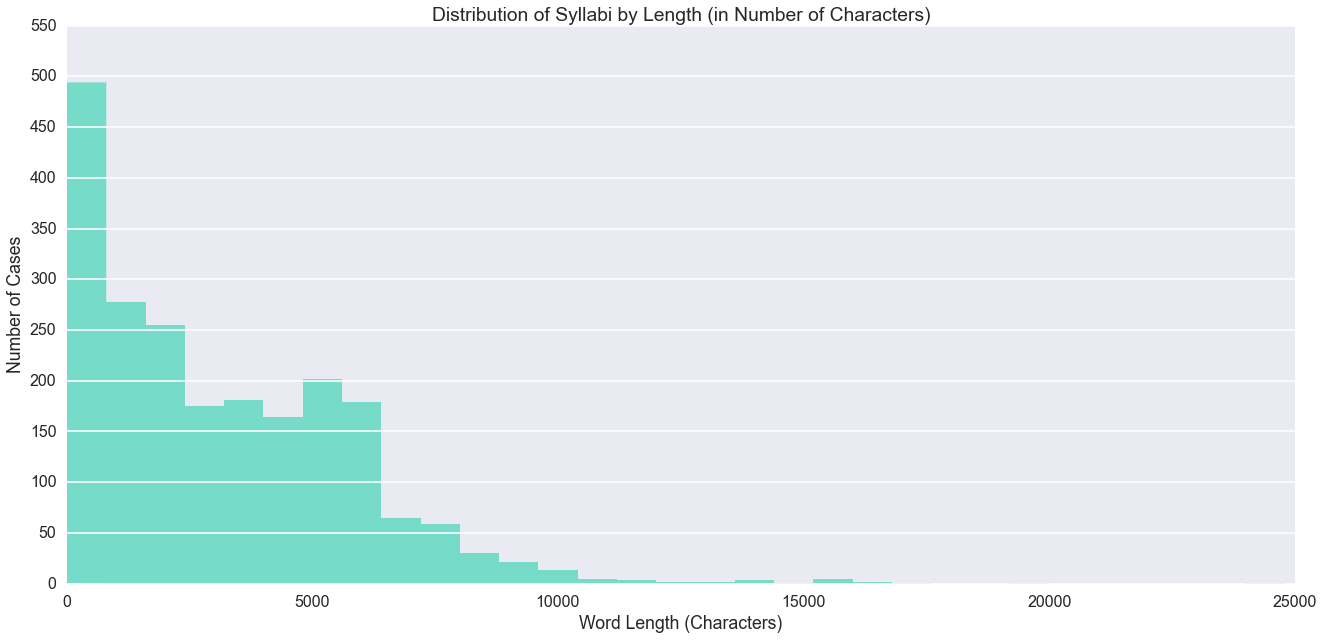

In [305]:
# get length of syllabi to determine which syllabi are undecided cases (ie, very short syllabi)
hist_textlength,textlength = [],[]
for index, row in sample_df.iterrows():
    l = len(str(row["text"]))
    textlength.append((l,row["case_id"]))
    hist_textlength.append(l)

# plot histogram of word length in chars
plt.figure(figsize=(22,10))
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.hist(hist_textlength,bins=np.arange(0, 25000, 800),color="#77dbc9",linewidth=0,zorder=0)
plt.title("Distribution of Syllabi by Length (in Number of Characters)")
plt.yticks(np.arange(0,600,50))
plt.ylabel("Number of Cases")
plt.xlabel("Word Length (Characters)")

# print percentiles
p5 = np.percentile(hist_textlength, 5) 
p25 = np.percentile(hist_textlength, 25) 
p50 = np.percentile(hist_textlength, 50) 
p75 = np.percentile(hist_textlength, 75) 
p95 = np.percentile(hist_textlength, 95) 
print "5th percentile: ", p5
print "25th percentile: ", p25
print "50th percentile: ", p50
print "75th percentile: ", p75
print "95th percentile: ", p95

We see that there are a lot of syllabi with very few characters. This is because there are a number of syllabi of cases that were not actually decided; the syllabus simply consists of the case name and nothing more. We want to remove these cases from our dataset. In the following cell, we figure out what the appropriate cutoff length is by looking at cases with different numbers of characters (a proxy for number of words) by looking at syllabi with various numbers of characters.

In [13]:
# function to find the text length closest to a given length 
closest = lambda num: min(hist_textlength, key=lambda x:abs(x-num))
textlength_dict = dict(textlength)

# we find the case id corresponding to the closest number, and print the corresponding text
test_lengths = [200,300,400,500,600,700,800]
for length in test_lengths:
    print "%d characters: " % length + "\n----------"
    print sample_df[sample_df["case_id"]==textlength_dict[closest(length)]].iloc[0]["text"] + "\n"

200 characters: 
----------
 PENSION BENEFIT GUARANTY CORPORATION v. YAHN & McDONNELL, INC., ET AL.  APPEAL FROM THE UNITED STATES COURT OF APPEALS FOR THE THIRD CIRCUIT  No. 86-231. Argued April 27, 1987 Decided May 18, 1987* 

300 characters: 
----------
 396 U.S. 803   PUBLIC UTILITY DIST. NO. 1 OF PEND OREILLE COUNTY, WASHINGTONv. CITY OF SEATTLE.No. 2.   CITY OF SEATTLEv. PUBLIC UTILITY DIST. NO. 1 OF PEND OREILLE COUNTY, WASHINGTON.No. 3.   Supreme Court of the United States   October Term, 1969.   October Term, 1969.   October 13, 1969 

400 characters: 
----------
 485 U.S. 916   David Joseph STEFFEN v. OHIO.No. 87-5323   Supreme Court of the United States   February 29, 1988 Rehearing Denied April 25, 1988.   See 485 U.S. 1030.   On petition for writ of certiorari to the Supreme Court of Ohio.   The petition for a writ of certiorari is denied.    Justice BRENNAN, with whom Justice MARSHALL joins and Justice BLACKMUN joins as to Part II, dissenting.   I  

500 characters: 
----

Based on our method of spot-checking syllabi texts, there seems no clear cutoff point. Because there is no non-arbitrary way to create a threshold, we eliminate all cases with text of fewer than 400 characters. (such cases seem unlikely to contain meaningful text, and we note that, for example, the 800-character case does have some information that does not relate to the disclaimer).

In [129]:
# exclude cases with fewer than 400 characters
for case in textlength:
    if case[0]<400: 
        sample_df = sample_df[sample_df["case_id"]!=case[1]]      

sample_df = sample_df.reset_index(drop=True)

###Incorporating Metadata from the Supreme Court Database
Our second data source is the Supreme Court Database (SCDB), which contains various metadata (including pre-labeled issue areas, decision directions, and voting outcomes) of cases. We upload this data here. Because the SCDB data includes a diverse and large set of columns (50+) that are either repetitive or unrelated to our analysis, we can select columns to accommodate the scope of our project.

In [15]:
# convert csv to dataframe, keep useful columns
scdb_df = pd.read_csv("SCDB_2015_01_caseCentered_Citation.csv")
scdb_df = scdb_df[['caseId','docketId','usCite','docket','caseName','dateArgument','caseOriginState','jurisdiction',\
                   'issueArea','decisionDirection','decisionType','lawType','majOpinWriter','majVotes','minVotes']]

In [16]:
scdb_df.tail()

,caseId,docketId,usCite,docket,caseName,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes
8626,2014-071,2014-071-01,NaN,14-7955,GLOSSIP v. GROSS,4/29/2015,NaN,1,1,1,1,2,112,5,4
8627,2014-072,2014-072-01,NaN,14-185,MATA v. LYNCH,4/29/2015,NaN,1,9,2,1,3,114,8,1
8628,2014-073,2014-073-01,NaN,14-618,WOODS v. DONALD,NaN,NaN,1,2,1,2,3,NaN,9,0
8629,2014-074,2014-074-01,NaN,14-593,GRADY v. NORTH CAROLINA,NaN,38,1,1,2,2,2,NaN,9,0
8630,2014-075,2014-075-01,NaN,14-939,TAYLOR v. BARKES,NaN,NaN,1,2,1,2,3,NaN,9,0


As we can tell by inspecting the tail of the dataframe, the Supreme Court Database data does not have U.S. cites for cases held in 2010 and beyond. Because this is the column that is most reliable to merge the Justia data on, we will need to complete the SCDB database by mapping U.S. cites to docket IDs. One way to accomplish this is by scraping this map from the comprehensive Wikipedia list of Supreme Court citations by volume.

In [17]:
# ---------- create a list of U.S. cites and volumes to map to SCDB data ----------

from bs4 import BeautifulSoup
import requests as rq
import re

# wikipedia lists all scotus cases by volume; scrape docket number to match u.s. cite format
url_stem = "https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_cases,_volume_"

# save U.S. cites and docket numbers
cites,cite_nums = [],[]

# for wikipedia pages before vol. 565, scrape unstructured list
for vol in range(558,565):
    soup = BeautifulSoup(rq.get(url_stem + str(vol)).text, "lxml")
    caselist = soup.find("div", attrs={"id":"mw-content-text"}).ul
    for case in caselist.findAll("li"):
        try:
            cite_num = case.text.split("No. ")[1][:-1]
        except IndexError:
            cite_num = case.text.split(", ")[1][:-1]
        cite_nums.append(cite_num)
        cites.append(str(vol) + " U.S. " + cite_num)

# for wikipedia pages vol. 565 and after, scrape table
for vol in range(565,576):
    soup = BeautifulSoup(rq.get(url_stem + str(vol)).text, "lxml")
    caselist = soup.find("table", attrs={"class":"wikitable plainlinks"})
    for cite in caselist.findAll("td", attrs={"style":"white-space:nowrap;"}):
        cite_num = cite.text
        cite_nums.append(cite_num)
        cites.append(str(vol) + " U.S. " + cite_num)

In [18]:
# create dataframe to merge U.S. cites 
cite_dict = {}
cite_dict["us_cite"] = cites
cite_dict["docket_num"] = cite_nums
citedf = pd.DataFrame(cite_dict)

In [136]:
# add a year column to SCDB data in order to subset 2010+ cases
scdb_df["year"] = [int(scdb_df["caseId"][x].split("-")[0]) for x in range(0,len(scdb_df))]
scdb_subset = scdb_df[scdb_df["year"] >= 2010]
scdb_merged = pd.merge(scdb_subset, citedf, left_on='docket', right_on='docket_num')

# merge the scraped mapped list with the 2010+ SCDB data
scdb_merged = scdb_merged.drop(["docket_num","usCite"],axis=1)
scdb_merged.rename(columns={"us_cite":"usCite"}, inplace=True)
scdb_merged = scdb_merged[['caseId','docketId','usCite','docket','caseName','dateArgument','caseOriginState','jurisdiction',\
                   'issueArea','decisionDirection','decisionType','lawType','majOpinWriter','majVotes','minVotes']]

# concatenate the updated 2010+ and pre-2010 SCDB data
final_scdb = pd.concat([scdb_df,scdb_merged])
final_scdb = final_scdb.reset_index()
final_scdb.tail()

,index,attorneys,caseId,caseName,caseOriginState,civil rights,criminal procedure,dateArgument,decisionDirection,decisionType,docket,docketId,due process,economic activity,federal taxation,federalism,first amendment,interstate amendment,issueArea,judicial power,jurisdiction,lawType,majOpinWriter,majVotes,minVotes,miscellaneous,privacy,private action,unions,usCite,year
8963,332,NaN,2014-065,HARRIS v. VIEGELAHN,NaN,NaN,NaN,4/1/2015,2,1,14-400,2014-065-01,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,1,3,109,9,0,NaN,NaN,NaN,NaN,575 U.S. 14-400,NaN
8964,333,NaN,2014-066,BULLARD v. BLUE HILLS BANK,NaN,NaN,NaN,4/1/2015,1,1,14-116,2014-066-01,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,1,3,111,9,0,NaN,NaN,NaN,NaN,575 U.S. 14-116,NaN
8965,334,NaN,2014-073,WOODS v. DONALD,NaN,NaN,NaN,NaN,1,2,14-618,2014-073-01,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,3,NaN,9,0,NaN,NaN,NaN,NaN,575 U.S. 14-618,NaN
8966,335,NaN,2014-074,GRADY v. NORTH CAROLINA,38,NaN,NaN,NaN,2,2,14-593,2014-074-01,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,2,NaN,9,0,NaN,NaN,NaN,NaN,575 U.S. 14-593,NaN
8967,336,NaN,2014-075,TAYLOR v. BARKES,NaN,NaN,NaN,NaN,1,2,14-939,2014-075-01,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,3,NaN,9,0,NaN,NaN,NaN,NaN,575 U.S. 14-939,NaN


In [137]:
# now we can successfully merge the Justia and SCDB data on U.S. cite
full_df = pd.merge(sample_df, final_scdb, left_on='us_cite', right_on='usCite')
full_df = full_df.drop(["index"],1)

# check that 2010+ cases are included
full_df.tail()

,full_cite,text,url,us_cite,case,case_id,attorneys,caseId,caseName,caseOriginState,civil rights,criminal procedure,dateArgument,decisionDirection,decisionType,docket,docketId,due process,economic activity,federal taxation,federalism,first amendment,interstate amendment,issueArea,judicial power,jurisdiction,lawType,majOpinWriter,majVotes,minVotes,miscellaneous,privacy,private action,unions,usCite,year
1616,Southern Construction Co. v. Pickard 371 U.S. ...,Southern Construction Co. v. Pickard No. 46 Ar...,https://supreme.justia.com/cases/federal/us/37...,371 U.S. 57,Southern Construction Co. v. Pickard,2350,0,1962-007,"SOUTHERN CONSTRUCTION CO., INC., et al. v. PIC...",NaN,0,0,10/16/1962,2,6,46,1962-007-01,0,0,0,0,0,0,9,1,1,3,NaN,9,0,0,0,0,0,371 U.S. 57,1962
1617,National Geographic Soc'y v. Board of Equal. 4...,National Geographic Society v. California Boar...,https://supreme.justia.com/cases/federal/us/43...,430 U.S. 551,National Geographic Soc'y v. Board of Equal.,6351,0,1976-080,NATIONAL GEOGRAPHIC SOCIETY v. CALIFORNIA BOAR...,6,0,0,2/23/1977,2,1,75-1868,1976-080-01,0,1,0,0,0,0,8,0,2,1,92,7,0,0,0,0,0,430 U.S. 551,1976
1618,Northern Ins. Co. of N. Y. v. Chatham County 5...,NORTHERN INSURANCE COMPANY OF NEW YORK v. CHAT...,https://supreme.justia.com/cases/federal/us/54...,547 U.S. 189,Northern Ins. Co. of N. Y. v. Chatham County,10582,0,2005-046,NORTHERN INSURANCE COMPANY OF NEW YORK v. CHAT...,NaN,0,0,3/1/2006,1,1,04-1618,2005-046-01,0,1,0,0,0,0,8,0,1,2,108,9,0,0,0,0,0,547 U.S. 189,2005
1619,Murray v. Carrier 477 U.S. 478 (1986),Murray v. Carrier No. 84-1554 Argued January 2...,https://supreme.justia.com/cases/federal/us/47...,477 U.S. 478,Murray v. Carrier,8286,0,1985-133,"MURRAY, DIRECTOR, VIRGINIA DEPARTMENT OF CORRE...",NaN,0,1,1/21/1986,1,1,84-1554,1985-133-01,0,0,0,0,0,0,1,0,1,NaN,104,7,2,0,0,0,0,477 U.S. 478,1985
1620,MARSHALL v. BRUCKER 356 U.S. 24 (1958),"MARSHALL v. BRUCKER, SECRETARY OF THE ARMY. ...",https://supreme.justia.com/cases/federal/us/35...,356 U.S. 24,MARSHALL v. BRUCKER,1605,0,1957-068,"MARSHALL v. BRUCKER, SECRETARY OF THE ARMY",NaN,1,0,NaN,2,2,41 M,1957-068-01,0,0,0,0,0,0,2,0,1,NaN,NaN,8,1,0,0,0,0,356 U.S. 24,1957


In [138]:
# simplify data 
full_df = full_df.drop("caseName",1)

In [139]:
# save sample dataframe for various models
full_df.to_csv("sample_cases.csv", sep=',', encoding='utf-8',index=False)

### Exploratory Analysis

We can conduct exploratory analysis using the Supreme Court Database data. It is interesting, for instance, to see how the cases are distributed along the axes of years, issue types (pre-labeled), majority and minority votes, and decision directions (a manually tagged column representing conservative and liberal opinions --- full documentation can be found [here](http://supremecourtdatabase.org/documentation.php?var=decisionDirection)).

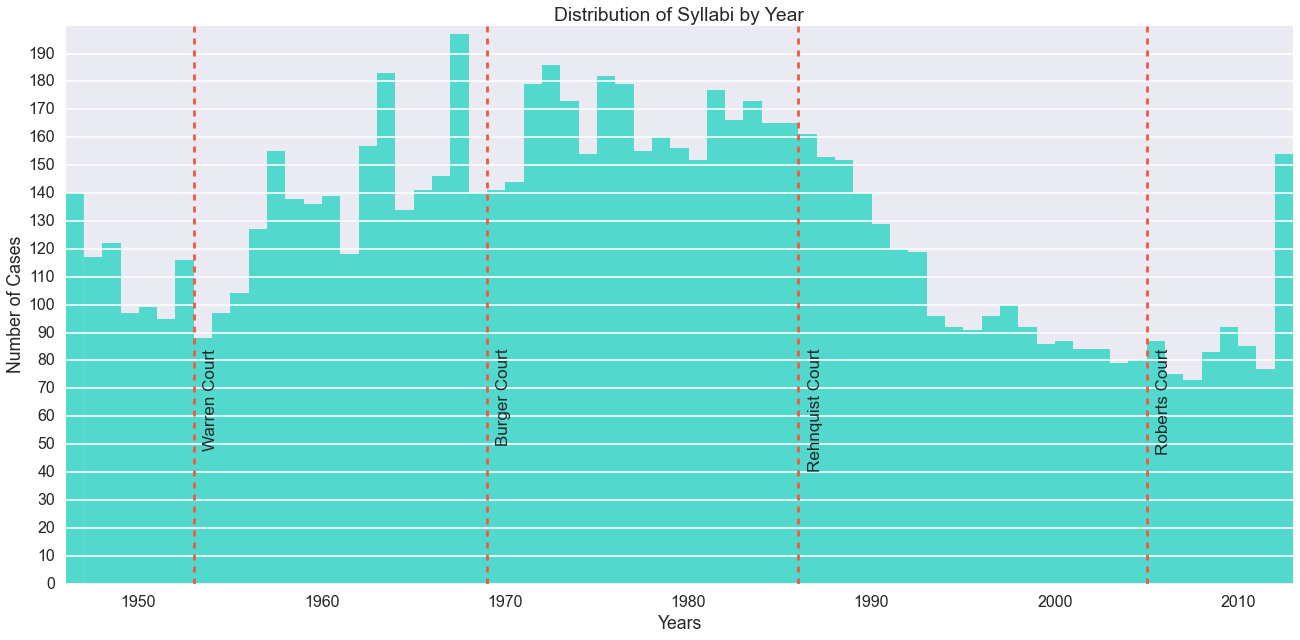

In [301]:
# plot distribution of all cases by year
plt.figure(figsize=(22,10))
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.hist(scdb_df.year, bins=np.arange(min(scdb_df.year),max(scdb_df.year),1),color="#53d8ce",linewidth=0,zorder=0)
plt.title("Distribution of Syllabi by Year")
plt.yticks(np.arange(0,200,10))
plt.ylabel("Number of Cases")
plt.xlabel("Years")
plt.xlim((min(scdb_df.year),max(scdb_df.year)-1))

# plot court eras for context
plt.axvline(1953,color="#f4593d",linestyle="dashed")
plt.text(1953.5,80,"Warren Court",rotation=90,size=17)
plt.axvline(1969,color="#f4593d",linestyle="dashed")
plt.text(1969.5,80,"Burger Court",rotation=90,size=17)
plt.axvline(1986,color="#f4593d",linestyle="dashed")
plt.text(1986.5,80,"Rehnquist Court",rotation=90,size=17)
plt.axvline(2005,color="#f4593d",linestyle="dashed")
plt.text(2005.5,80,"Roberts Court",rotation=90,size=17)

plt.show()

In [160]:
# turn issue areas into dummy column
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]

for issue, num in zip(issue_areas,range(1,15)):
    scdb_df[issue] = scdb_df.issueArea.apply(lambda x: 1 if x == num else 0)

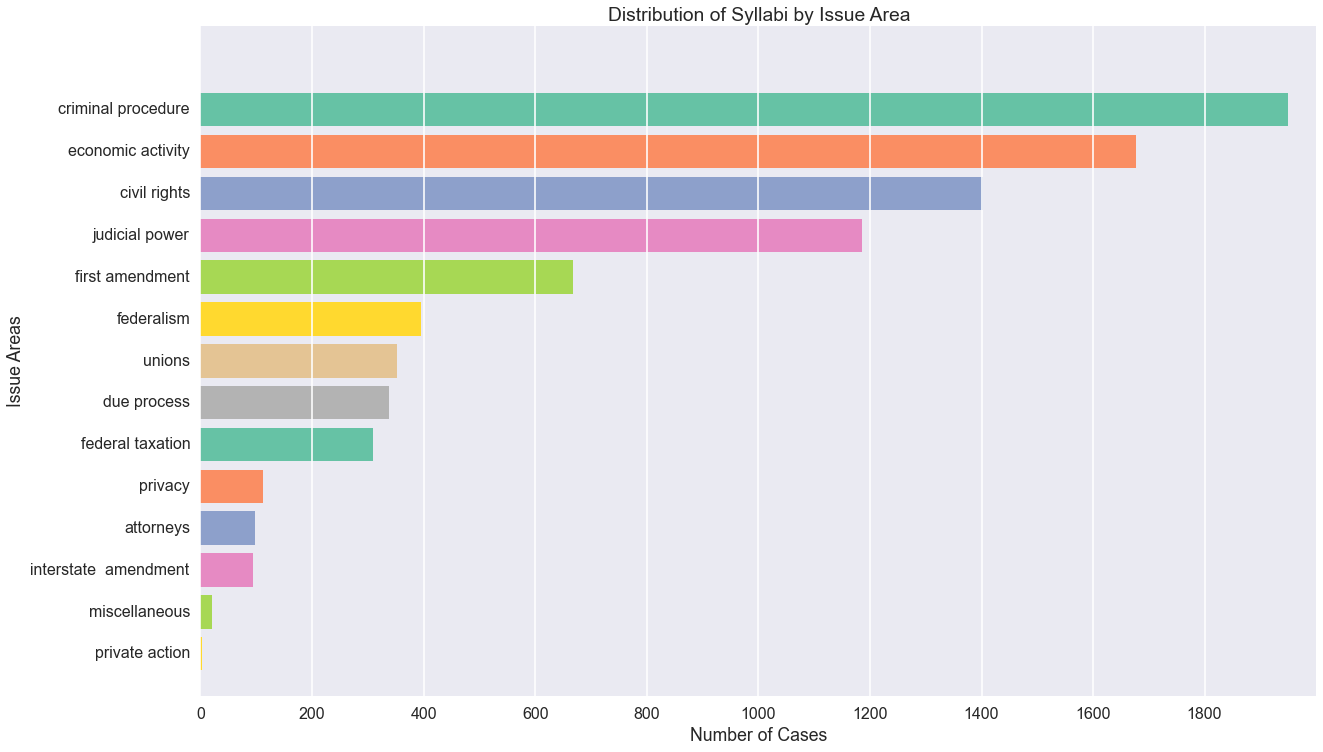

In [192]:
# plot distribution of all cases by issue type
import collections

issue_dict = {}
for issue in issue_areas:
    issue_dict[issue] = sum(scdb_df[issue])

sorted_dict = collections.OrderedDict()
sorted_vals = sorted(issue_dict.values(),reverse=True)
sorted_keys = sorted(issue_dict, key=issue_dict.get,reverse=True)
for key, val in zip(sorted_keys,sorted_vals):
    sorted_dict[key] = val

plt.figure(figsize=(20,12))
plt.grid(zorder=3)
plt.barh(range(len(sorted_dict)),sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0)
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_dict)),sorted_dict.keys())
plt.xticks(np.arange(0,2000,200))
plt.title("Distribution of Syllabi by Issue Area")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Areas")
plt.show()

In [205]:
# turn decision directions into dummy column (conservative, liberal, neutral)
decision_areas = ["conservative","liberal","neutral"]

for decision, num in zip(decision_areas,range(1,4)):
    scdb_df[decision] = scdb_df.decisionDirection.apply(lambda x: 1 if x == num else 0)

We can check to see if the random sample that we collected contains a similar distribution to the ones above.

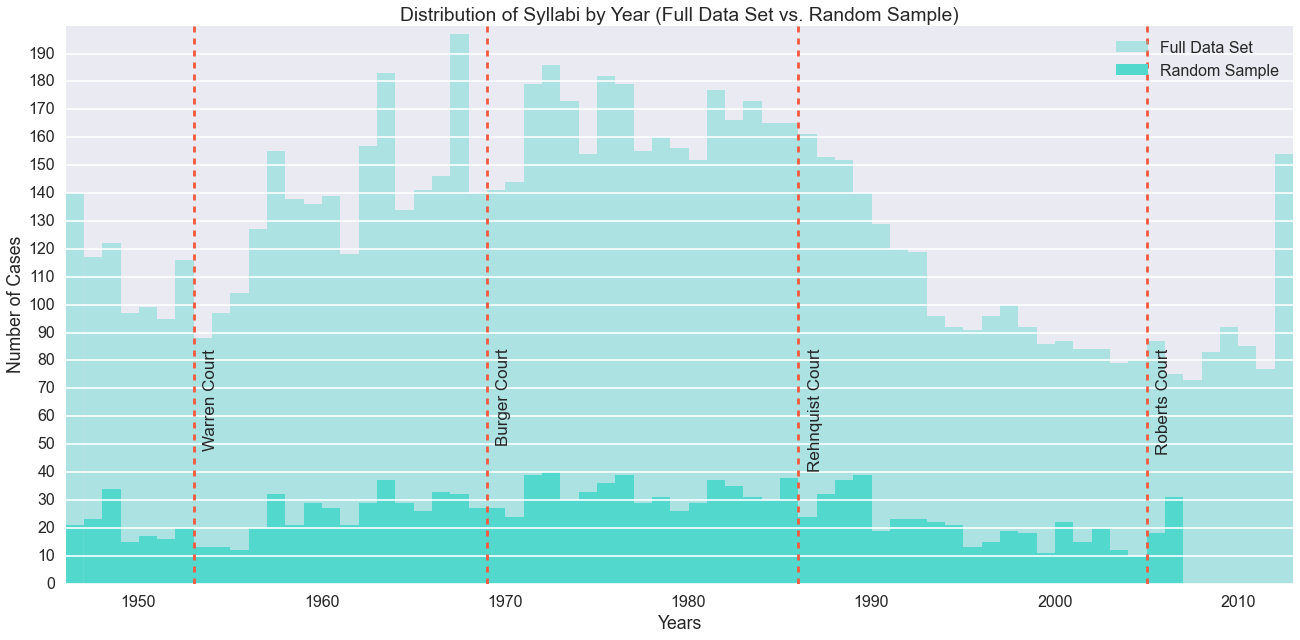

In [300]:
# plot distribution of all cases by year
plt.figure(figsize=(22,10))
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.hist(scdb_df.year, bins=np.arange(min(scdb_df.year),max(scdb_df.year),1),color="#53d8ce",linewidth=0,alpha=0.4,zorder=0,label="Full Data Set")
plt.hist(full_df.year, bins=np.arange(min(full_df.year),max(full_df.year),1),color="#53d8ce",linewidth=0,zorder=0,label="Random Sample")
plt.title("Distribution of Syllabi by Year (Full Data Set vs. Random Sample)")
plt.yticks(np.arange(0,200,10))
plt.ylabel("Number of Cases")
plt.xlabel("Years")
plt.xlim((min(scdb_df.year),max(scdb_df.year)-1))
plt.legend()

# plot court eras for context
plt.axvline(1953,color="#f4593d",linestyle="dashed")
plt.text(1953.5,80,"Warren Court",rotation=90,size=17)
plt.axvline(1969,color="#f4593d",linestyle="dashed")
plt.text(1969.5,80,"Burger Court",rotation=90,size=17)
plt.axvline(1986,color="#f4593d",linestyle="dashed")
plt.text(1986.5,80,"Rehnquist Court",rotation=90,size=17)
plt.axvline(2005,color="#f4593d",linestyle="dashed")
plt.text(2005.5,80,"Roberts Court",rotation=90,size=17)

plt.show()

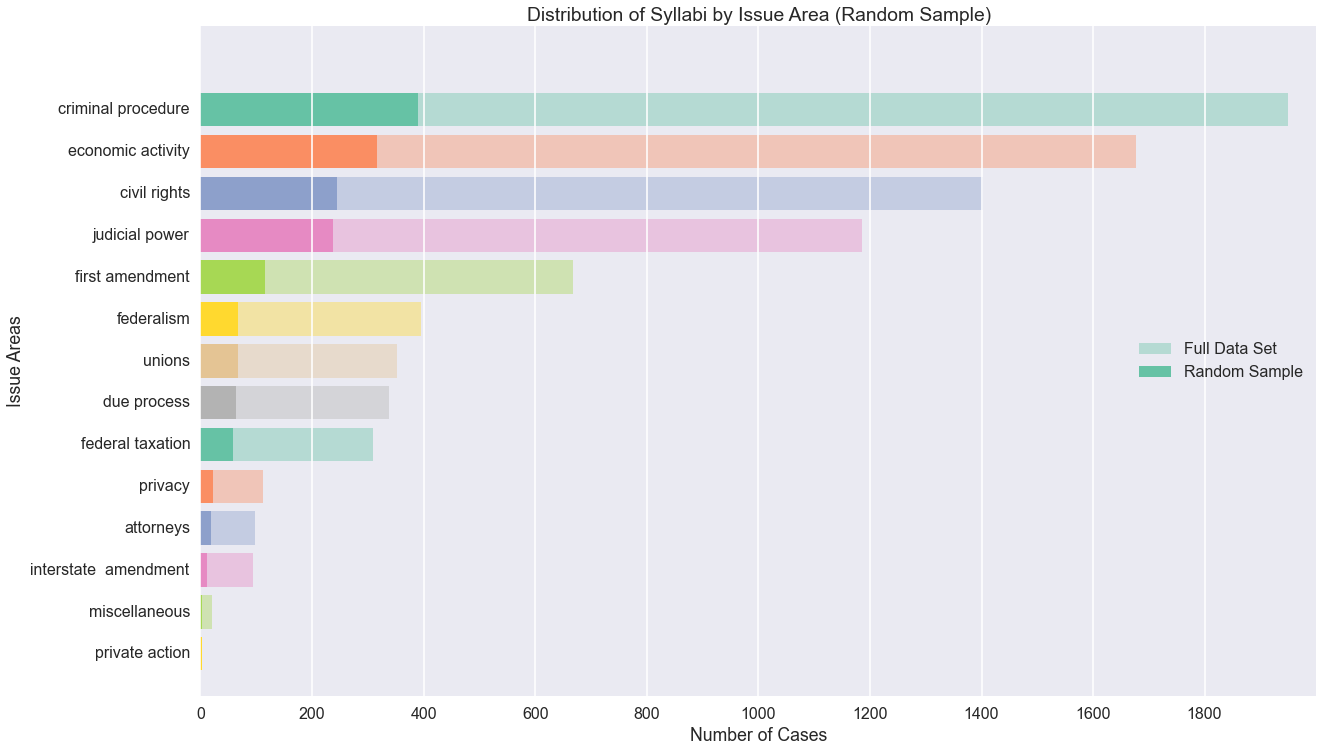

In [193]:
# turn issue areas into dummy column
for issue, num in zip(issue_areas,range(1,15)):
    full_df[issue] = full_df.issueArea.apply(lambda x: 1 if x == num else 0)
    
# plot distribution of all cases by issue type
samp_issue_dict = {}
for issue in issue_areas:
    samp_issue_dict[issue] = sum(full_df[issue])

samp_sorted_dict = collections.OrderedDict()
samp_sorted_vals = sorted(samp_issue_dict.values(),reverse=True)
samp_sorted_keys = sorted(samp_issue_dict, key=issue_dict.get,reverse=True)
for key, val in zip(samp_sorted_keys,samp_sorted_vals):
    samp_sorted_dict[key] = val

plt.figure(figsize=(20,12))
plt.grid(zorder=3)
plt.barh(range(len(sorted_dict)),sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),alpha=0.4,linewidth=0,zorder=0,label="Full Data Set")
plt.barh(range(len(samp_sorted_dict)),samp_sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0,label="Random Sample")
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_dict)),sorted_dict.keys())
plt.title("Distribution of Syllabi by Issue Area (Random Sample)")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Areas")
plt.legend(loc="center right")
plt.xticks(np.arange(0,2000,200))
plt.show()

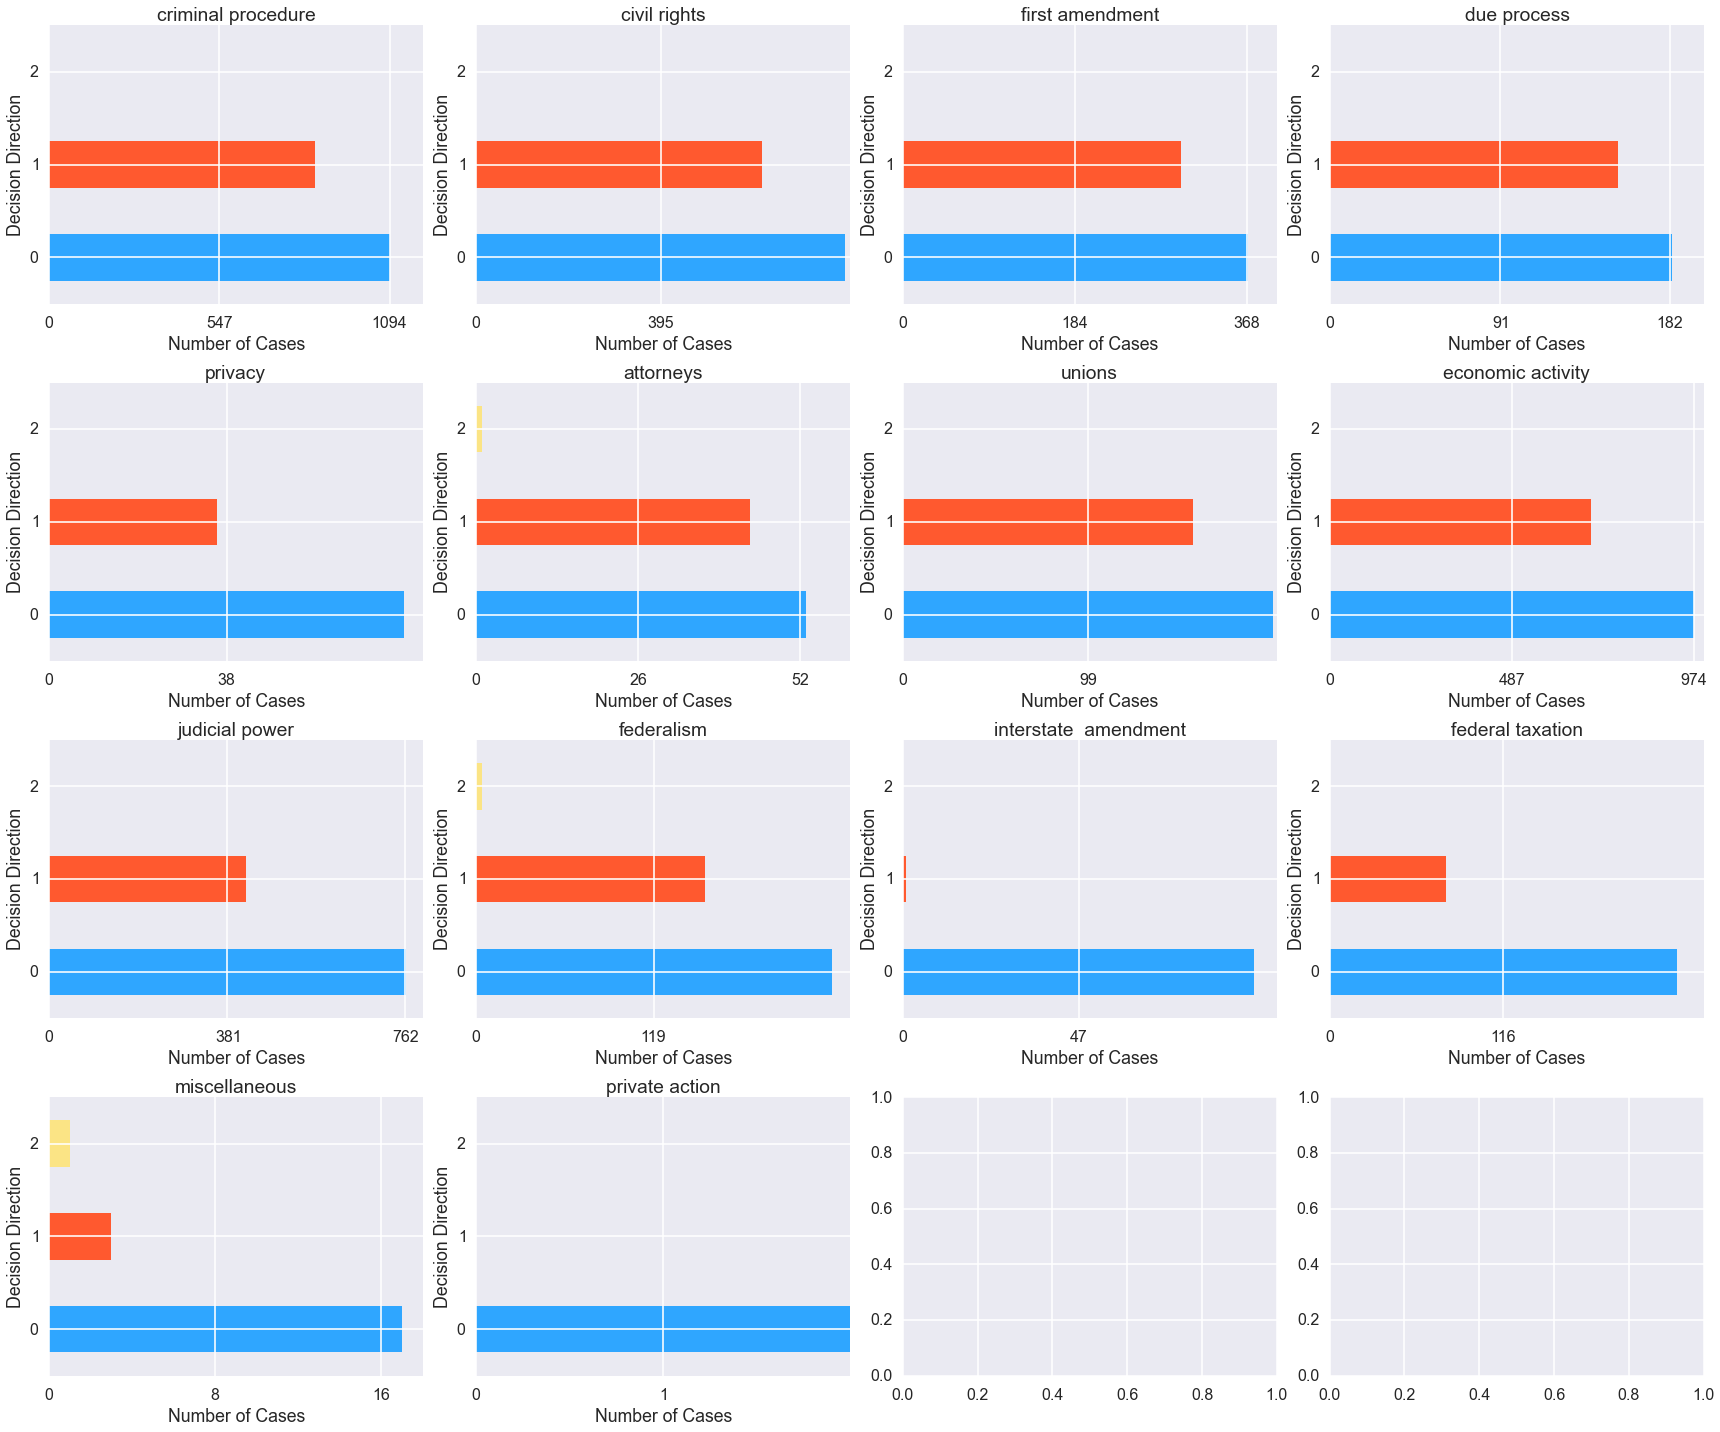

In [270]:
# plot distribution of partisanship by issue area 

# create subplot of 4 rows x 4 cols
fig, ax = plt.subplots(4, 4, figsize=(24, 20), tight_layout=True)

# index of issue area
x = 1

# iterate through rows, cols of subplot grid, populate with kde
for r in range(0,4):
    for c in range(0,4):
        ax[r][c].set_title(issue_areas[x-1])
        
        decision_dict = {}
        for decision in decision_areas:
            decision_dict[decision] = sum(scdb_df[scdb_df["issueArea"] == x][decision])

        sorted_dec_dict = collections.OrderedDict()
        sorted_dec_vals = sorted(decision_dict.values(),reverse=True)
        sorted_dec_keys = sorted(decision_dict, key=decision_dict.get,reverse=True)
        for key, val in zip(sorted_dec_keys,sorted_dec_vals):
            sorted_dec_dict[key] = val
            
        ax[r][c].grid(zorder=3)
        ax[r][c].barh(range(len(sorted_dec_dict)),sorted_dec_dict.values(),align='center',color=["#2fa6ff","#ff592f","#fbe485"],height=0.5,linewidth=0,zorder=0)
        ax[r][c].set_yticks([0,1,2])
        ax[r][c].set_xticks(np.arange(0,max(sorted_dec_dict.values()),max(sorted_dec_dict.values())/2))
        ax[r][c].set_xlabel("Number of Cases")
        ax[r][c].set_ylabel("Decision Direction")

        x = x + 1
        
        if x == 15:
            break

plt.show()

\*\*\* *Liberal = 0, Conservative = 1, Neutral = 2*
<br><br>
We can see that for all subject areas, there are more liberal opinions reached than conservative opinions. 